# Mapping Murdock's Ethnographic Atlas
## using geopandas and folium 
### (relevant to a replication of James Fenske's paper)

This notebook illustrates how to do mapping and some geospatial analysis inside of a juptyer notebook using various python libraries.  All of these steps can of course be done inside of dedicated GIS client such as QGIS but it's nice to be able to do many of the same tasks inside of a notebook for better documentation and automation. 

The notebook illustrates how to load and display vector polygon as well as raster geospatial data. There are many ways to do this with python but we focus here on using [geopandas](https://github.com/geopandas/geopandas) with [folium](http://python-visualization.github.io/folium/) in a supporting role (to make things look more cool on interactive slippy maps using [leaflet.js](http://leafletjs.com/)).  We use the [rasterio](https://github.com/mapbox/rasterio) and [rasterstats](http://pythonhosted.org/rasterstats/) libraries to work with raster data. 

Broad outline:

1. load vector polygon from [Morduck's Ethnographic Atlas](http://devecondata.blogspot.com/2007/10/ethnographic-atlas.html)  data digitized by Nathan Nunn. We'll display the data and show how to also plot markers on a different map layer.

2. Load and display gridded raster data on wheat suitability. 

3. Calculate raster zonal statistics 

4. (not finished) Discuss how data such as that constructed in step 3 was used in an empirical paper by James Fenske...

In [1]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')

First create a folium slippy basemap. 

In [2]:
m = folium.Map(
    location = [-1, 25], 
    zoom_start=4, 
    tiles='cartodbpositron'
)

We use `FeatureGroup`s to add feature layers that we can later turn off and on via LayerControl

We will have different folium map layers or FeatureGroups. 

The `marker_group` below is just a collection of markers (all appear at once). 
The `marker_cluster` will, depending on zoom level, cluster markers into groups to make the map less cluttered. We turn on only one of the marker feature groups at a time.

The polygon group will have tribal group borders. 

In [3]:
poly_group = folium.FeatureGroup(name='Tribes')
marker_group = folium.FeatureGroup(name='Markers')
marker_cluster = folium.MarkerCluster().add_to(m)

#### Morduck's Ethnographic Atlas
Shapefile [digitized by Nathan Nunn](https://scholar.harvard.edu/nunn/pages/data-0) 
We import this shapefile into a geopandas dataframe:

In [4]:
tribe_areas = gpd.GeoDataFrame.from_file('borders_tribes.shp')
tribe_areas.head(3)

NAME  TRIBE_CODE        LAT       LON  \
0    ABABDA           1  23.161800  33.70160   
1  ABARAMBO           2   3.702955  26.79730   
2       ABE           3   6.069531  -4.26032   

                                            geometry  
0  POLYGON ((35.73971002025493 22.87610925401416,...  
1  POLYGON ((26.45080101160396 3.392839235868952,...  
2  POLYGON ((-4.074770016825197 6.375219238646509...

geopandas is a powerful python library. Among many other things it allows us to plot:

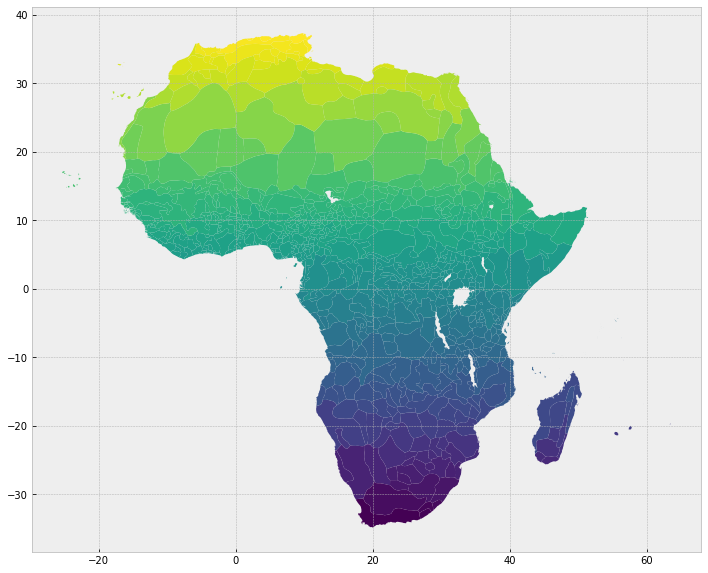

In [5]:
tribe_areas.plot(column='LAT', figsize=(12,16));

But this is a static map. For exploratory purposes it's nice to pass the information in the dataframe to folium to map things on top of a slippy map.  

The following adds the polygon information from our geopandas dataframe to the `poly_group` map layer that we will use below with folium.

In [6]:
folium.GeoJson(tribe_areas).add_to(poly_group);

##### Markers
We'll iterate through the ethnic groups and create a marker for each group to be located at the Lat, Lon position recorded in the geopandas data frame and labeled with the ethnic group name. 

In [7]:
for i, row in tribe_areas.iterrows():
    folium.Marker(
        location=[row.LAT, row.LON],
        popup = row.NAME).add_to(marker_cluster)  # or replace with marker_group

We choose which of these FeatureGroups to add to the folium map and add a `LayerControl` to allow us to selectively turn these layers on or off.

**NOTE**: the map that follows will not be seen in static views of this notebook (as you might see on github). See this [saved HTML rendering](https://cdn.rawgit.com/jhconning/land_uct_2018/cbc64c77/notebooks/tribes.html) (which should be interactive)

In [8]:
marker_group.add_to(m)
#marker_cluster.add_to(m)
poly_group.add_to(m)

folium.LayerControl().add_to(m)

m

Save the map to an HTML file to be browsed as a standalone in a larger window.

In [9]:
m.save('tribes.html')

## Raster data, zonal statistics

We want to calculate zonal statistics (in this case statistics for data that falls inside the ethnic group boundaries).  Here we'll get data on wheat yield potential which comes as raster data from FAO-GAEZ. Each gridpoint on the raster is associated with a suitability index.  We'll calculate mean suitability in each of the polygons associated with Murdock/Nunn data.

In [10]:
import rasterio
import rasterio.plot as rioplot
import rasterstats as rs

Get first downloaded raster data on potential crop yields from FAO-GAEZ data.  Looks like this. 

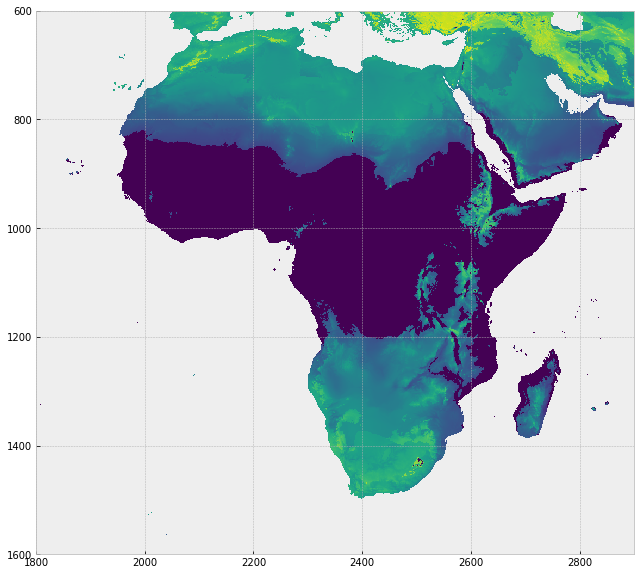

In [11]:
wheat = rasterio.open("res02_crav6190h_whea000a_yld.tif")
plt.figure(figsize=(12,10))
plt.xlim(1800,2900)
plt.ylim(1600,600)
rioplot.show(wheat);

Next we use the `rasterstats.zonal_stats` command to calculate 'count', 'max', 'min', 'mean' statistics for the raster data inside each polygon. The function returns the results as a python dictionary.

In [12]:
stats = rs.zonal_stats('borders_tribes.shp','res02_crav6190h_whea000a_yld.tif', prefix = 'wheat_')

C:\Users\jconning\AppData\Local\Continuum\Anaconda3\lib\site-packages\rasterstats\main.py:142: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
C:\Users\jconning\AppData\Local\Continuum\Anaconda3\lib\site-packages\rasterstats\io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)


Finally let us add these calculated statistics as columns to our geodataframe.

In [13]:
colnames = pd.DataFrame(stats).columns.tolist()
colnames

['wheat_count', 'wheat_max', 'wheat_mean', 'wheat_min']

In [14]:
tribe_areas[colnames] = pd.DataFrame(stats)
tribe_areas.head()

NAME  TRIBE_CODE        LAT       LON  \
0    ABABDA           1  23.161800  33.70160   
1  ABARAMBO           2   3.702955  26.79730   
2       ABE           3   6.069531  -4.26032   
3    ACHOLI           4   3.108121  32.65680   
4   ADAMAWA           5   7.556091  13.18470   

                                            geometry  wheat_count  wheat_max  \
0  POLYGON ((35.73971002025493 22.87610925401416,...         1988     7443.0   
1  POLYGON ((26.45080101160396 3.392839235868952,...           82        0.0   
2  POLYGON ((-4.074770016825197 6.375219238646509...           48        0.0   
3  POLYGON ((33.25899701794458 3.885389236327675,...          319     5564.0   
4  POLYGON ((14.14605000014426 9.969429241993879,...          620     6395.0   

    wheat_mean  wheat_min  
0  5184.301811        0.0  
1     0.000000        0.0  
2     0.000000        0.0  
3    32.824451        0.0  
4   159.106452        0.0

Let's see a simple chloropeth plot based on mean wheat potential in each ethnic group zone.

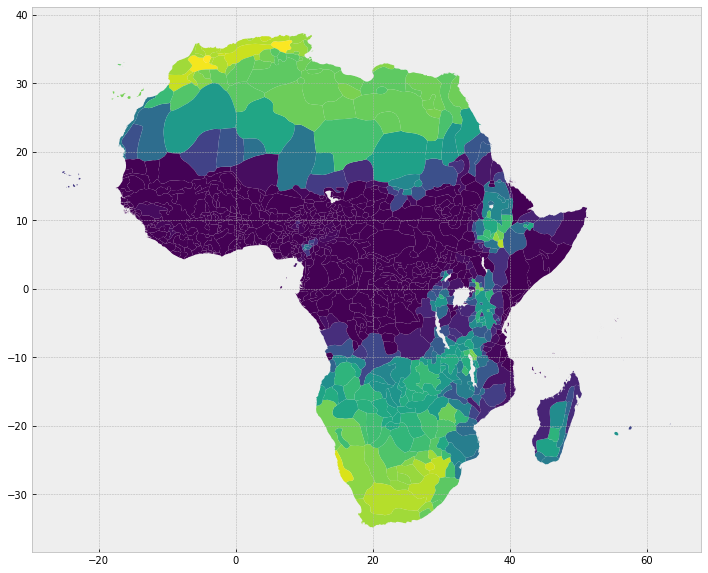

In [15]:
tribe_areas.plot(column='wheat_mean', figsize=(12,16));

## James Fenske's regressions

    Fenske, James. 2013. “Does Land Abundance Explain African Institutions?” The Economic Journal 123 (573):1363–1390.

To his great credit James Fenske posts data and code to replicate most of his published papers to his [website](https://sites.google.com/site/jamesfenske/Research)

Several of his right hand variables in the regressions in tables X, Y Z were constructed using methods such as those described above.


More to follow...